# Importing libraries and initializing spark session

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import os

spark =( SparkSession.builder
    .appName("Pipeline2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.repl.eagerEval.maxNumRows", 10)
    .config("spark.sql.shuffle.partitions", 20)
    .config("spark.sql.sources.partitionColumnTypeInference.enabled", True)
    .getOrCreate())

CITI_DIRECTORY = "gs://bucket121024/pipeline1/final_output.parquet"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/21 02:21:04 INFO SparkEnv: Registering MapOutputTracker
24/12/21 02:21:04 INFO SparkEnv: Registering BlockManagerMaster
24/12/21 02:21:04 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/21 02:21:04 INFO SparkEnv: Registering OutputCommitCoordinator


# Reading citibike combined data

In [2]:
data = spark.read.parquet(CITI_DIRECTORY)
# data = data.repartition(60)

In [3]:
data.printSchema()

root
 |-- bikeid: string (nullable = true)
 |-- birthyear: string (nullable = true)
 |-- endlatitude: string (nullable = true)
 |-- endlongitude: string (nullable = true)
 |-- endstationid: string (nullable = true)
 |-- endstationname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- membercasual: string (nullable = true)
 |-- rideabletype: string (nullable = true)
 |-- rideabletypeduplicatecolumnname1: string (nullable = true)
 |-- rideid: string (nullable = true)
 |-- startlatitude: string (nullable = true)
 |-- startlongitude: string (nullable = true)
 |-- startstationid: string (nullable = true)
 |-- startstationname: string (nullable = true)
 |-- starttime: string (nullable = true)
 |-- stoptime: string (nullable = true)
 |-- tripduration: string (nullable = true)
 |-- unnamed:0: integer (nullable = true)
 |-- usertype: string (nullable = true)



In [4]:
format_1 = "MM/dd/yyyy H:mm:ss"  # Handles single-digit hours (e.g., "2/1/2015 0:00:00")
format_2 = "yyyy-MM-dd HH:mm:ss[.SSSS]"  # ISO format (e.g., "2016-09-01 00:00:02")
format_3 = "M/d/yyyy H:mm"  # Handles single-digit hours without seconds (e.g., "2/1/2015 0:00")

data = data.withColumn(
    "starttime_standardized",
    F.when(
        F.col("starttime").rlike(r"^\d{1,2}/\d{1,2}/\d{4} \d{1,2}:\d{2}:\d{2}$"),  # Matches MM/dd/yyyy H:mm:ss
        F.concat(
            F.split(F.split(F.col("starttime"), "/")[2], " ")[0],  # Year: Take the part after the last "/"
            F.lit("-"),
            F.lpad(F.split(F.col("starttime"), "/")[0], 2, "0"),  # Month: Add leading zero if necessary
            F.lit("-"),
            F.lpad(F.split(F.col("starttime"), "/")[1], 2, "0"),  # Day: Add leading zero if necessary
            F.lit(" "),
            F.split(F.col("starttime"), " ")[1]  # Time part (H:mm:ss)
        )
    ).otherwise(F.col("starttime"))
)

data = data.withColumn(
    "starttime_parsed",
    F.when(
        F.to_timestamp(F.col("starttime_standardized"), format_2).isNotNull(),
        F.to_timestamp(F.col("starttime_standardized"), format_2)
    ).when(
        F.to_timestamp(F.col("starttime_standardized"), format_1).isNotNull(),
        F.to_timestamp(F.col("starttime_standardized"), format_1)
    ).otherwise(
        F.to_timestamp(F.col("starttime_standardized"), format_3)
    )
)

# unmatched_dates = data.filter(F.col("starttime_parsed").isNull())

# unmatched_dates.select("starttime").show(truncate=False)


In [5]:
data = data.withColumn("date", F.to_date("starttime_parsed"))
data = data.withColumn("hour", F.hour("starttime_parsed"))
data = data.withColumn("day_of_week", F.dayofweek("starttime_parsed"))
data = data.withColumn("month", F.month("starttime_parsed"))
data = data.withColumn("year", F.year("starttime_parsed"))

In [6]:
demand_data = data.groupBy("startstationname", "day_of_week", "month", "date", "hour", "year").agg(F.count("*").alias("demand"))


In [7]:

demand_data = demand_data.dropna()

In [8]:
#demand_data.describe()



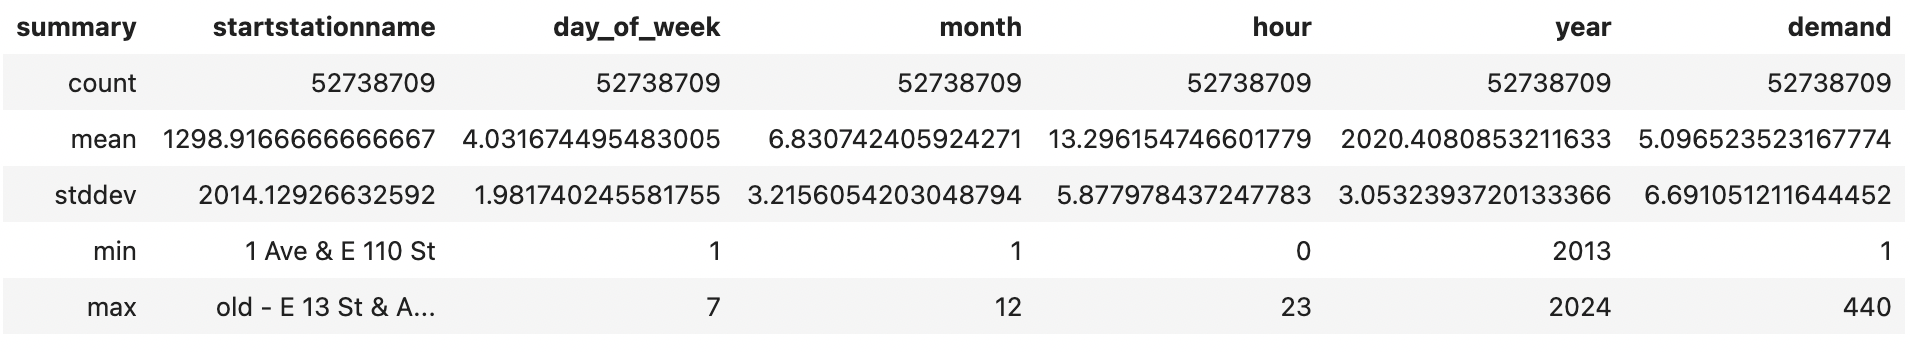

In [9]:
mean_demand = 5.096523523167774
stddev_demand = 6.691051211644452

df_with_zscore = demand_data.withColumn(
    "z_score", (F.col("demand") - mean_demand) / stddev_demand
)

outliers = df_with_zscore.filter(
    (F.col("z_score") > 3) | (F.col("z_score") < -3)
)


# outliers.show()
# Filter data to remove outliers
demand_data = df_with_zscore.filter(
    (F.col("z_score") <= 3) & (F.col("z_score") >= -3)
)

# Drop the z_score column if it's no longer needed
demand_data = demand_data.drop("z_score")



In [10]:
# Load Weather Data
weather_path = "gs://bucket121024/w_data/nyc_w_data_full.csv"
weather_data = spark.read.csv(weather_path, header=True, inferSchema=True)

# Process Weather Data: Extract date, hour, day_of_week, and month
weather_data = weather_data.withColumn("date", F.to_date("datetime", "yyyy-MM-dd"))
weather_data = weather_data.withColumn("hour", F.hour(F.col("datetime")))
weather_data = weather_data.withColumn("day_of_week", F.dayofweek(F.col("date")))
weather_data = weather_data.withColumn("month", F.month(F.col("date")))
weather_data = weather_data.withColumn("year", F.year("date"))
# weather_data

In [11]:
weather_data.printSchema()

root
 |-- name: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- precipprob: integer (nullable = true)
 |-- preciptype: string (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windgust: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- winddir: double (nullable = true)
 |-- sealevelpressure: double (nullable = true)
 |-- cloudcover: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- solarradiation: double (nullable = true)
 |-- solarenergy: double (nullable = true)
 |-- uvindex: integer (nullable = true)
 |-- severerisk: string (nullable = true)
 |-- conditions: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- stations: string (nullable = true)
 |-- date: date (nullab

In [12]:
print("NULL Count Per Column:")
# null_counts = weather_data.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in weather_data.columns])
# null_counts

NULL Count Per Column:


In [13]:
weather_data = weather_data.drop(*['name', 'feelslike', 'dew', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust', 'winddir', 
              'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'icon', 'stations'])

In [14]:
# Merge Citi Bike and Weather Data
merged_data = demand_data.join(weather_data, ["date", "day_of_week", "month", "hour", "year"], "left")
# merged_data = merged_data.sample(withReplacement=False, fraction=0.1, seed=42)

merged_data.printSchema()

root
 |-- date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- startstationname: string (nullable = true)
 |-- demand: long (nullable = false)
 |-- datetime: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- visibility: double (nullable = true)
 |-- conditions: string (nullable = true)



In [15]:
#merged_data

In [16]:
# Add weekend indicator
merged_data = merged_data.withColumn("is_weekend", F.when(F.col("day_of_week").isin(1, 7), F.lit(1)).otherwise(F.lit(0)))

# Add COVID lockdown days indicator
lockdown_start = "2020-03-15"
lockdown_end = "2020-06-30"
merged_data = merged_data.withColumn("is_lockdown", F.when((F.col("date") >= F.lit(lockdown_start)) & (F.col("date") <= F.lit(lockdown_end)), F.lit(1)).otherwise(F.lit(0)))
merged_data = merged_data.withColumn("is_weekend", F.when(F.col("day_of_week").isin(1, 7), F.lit(1)).otherwise(F.lit(0)))

# Select features and target column
feature_cols = ["day_of_week", "month", "hour", "year", "temp", "humidity", 
                "precip",  "windspeed", "visibility", 
                 "is_weekend", "is_lockdown"]
#Handling categorical features
if "conditions" in merged_data.columns:
    conditions_indexer = StringIndexer(inputCol="conditions", outputCol="conditions_indexed", handleInvalid="keep")
    merged_data = conditions_indexer.fit(merged_data).transform(merged_data)
    feature_cols.append("conditions_indexed")

if "startstationname" in merged_data.columns:
    station_indexer = StringIndexer(inputCol="startstationname", outputCol="startstationname_indexed", handleInvalid="keep")
    merged_data = station_indexer.fit(merged_data).transform(merged_data)
    feature_cols.append("startstationname_indexed")

In [17]:
from pyspark.sql.window import Window
demand_window = Window.partitionBy("startstationname").orderBy("datetime")
merged_data = merged_data.withColumn("lag_demand_1", F.lag("demand", 1).over(demand_window))
merged_data = merged_data.withColumn("rolling_avg_demand", F.avg("demand").over(demand_window.rowsBetween(-3, 0)))
feature_cols.extend(["lag_demand_1", "rolling_avg_demand"])

In [18]:
merged_data = merged_data.withColumn("hour_bucket", F.when(F.col("hour").between(6, 11), "morning")
                                                .when(F.col("hour").between(12, 17), "afternoon")
                                                .when(F.col("hour").between(18, 23), "evening")
                                                .otherwise("night"))
hour_bucket_indexer = StringIndexer(inputCol="hour_bucket", outputCol="hour_bucket_indexed")
merged_data = hour_bucket_indexer.fit(merged_data).transform(merged_data)
feature_cols.append("hour_bucket_indexed")


In [19]:
merged_data = merged_data.withColumn("temp_is_weekend", F.col("temp") * F.col("is_weekend"))
merged_data = merged_data.withColumn("humidity_is_weekend", F.col("humidity") * F.col("is_weekend"))
feature_cols.extend(["temp_is_weekend", "humidity_is_weekend"])


In [20]:
merged_data = merged_data.na.fill({"lag_demand_1": 0, "rolling_avg_demand": 0})


In [22]:
#merged_data.write.mode("overwrite").parquet("gs://bucket121024/pipeline2/merged_data.parquet")


In [28]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, col

window_spec = Window.orderBy("datetime")
ordered_data = merged_data.withColumn("row_num", row_number().over(window_spec))


In [29]:
cached_data = ordered_data.cache()

24/12/21 02:39:33 WARN CacheManager: Asked to cache already cached data.


In [30]:

total_rows = ordered_data.count()

split_point = int(total_rows * 0.8)

train_data = ordered_data.filter(col("row_num") <= split_point).drop("row_num")
test_data = ordered_data.filter(col("row_num") > split_point).drop("row_num")
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")

24/12/21 02:39:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:39:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:39:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:39:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:41:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:41:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 0

Training Data Count: 41407113


Testing Data Count: 10351779


In [31]:
train_data.write.mode("overwrite").parquet("gs://bucket121024/pipeline2/train_data.parquet")
test_data.write.mode("overwrite").parquet("gs://bucket121024/pipeline2/test_data.parquet")


24/12/21 02:49:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:49:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/21 02:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
